지난 시간까지는, 주로 랜덤포레스트만을 이용하여 예측을 수행했습니다. 
이번 시간에는 더욱 다양한 분석기법을 활용해 케글 점수를 향상시킵니다. 

# 분석환경 조성하기 

## 라이브러리 로드하기 

In [1]:
# 연산 및 데이터 프레임화를 위한 라이브러리들 
import pandas as pd 
import numpy as np 

# 시각화 라이브러리들 
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns 
# 주피터 노트북 내부에 그래프를 표시하기 위한 설정 
%matplotlib inline 

#그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 사용 
plt.style.use("ggplot")
#그래프에서 마이너스 폰트가 깨지는 문제에 대한 대처 
mpl.rcParams["axes.unicode_minus"] = False 

import warnings 
warnings.filterwarnings("ignore")

[python | warning module]("https://docs.python.org/ko/dev/library/warnings.html")

In [2]:
#구글 드라이브 연동하기
#구글 드라이브에 데이터를 올린 후 사용할 경우에만 실행
## from google.colab import drive
## drive.mount('/content/drive')

## 분석할 데이터 로드하기 
* 데이터를 각각 train 데이터와 test 데이터로 불러옵니다 

In [3]:
train = pd.read_csv("data_sets/bike_sharing_demand/train.csv",parse_dates=["datetime"])
print(train.shape)

train.head()

(10886, 12)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
test = pd.read_csv("data_sets/bike_sharing_demand/test.csv", parse_dates=["datetime"])

print(test.shape)
test.head()

(6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


## 데이터 사전 처리 
* datetime 컬럼을 세분화하여 feature를 추가합니다. 

In [5]:
# 날짜를 분할해 (년,월,시간,요일) 특성을 추가 합니다. 
# 먼저 훈련데이터셋을 조작합니다. 

train["year"] = train["datetime"].dt.year
train["month"] = train["datetime"].dt.month
train["hour"] = train["datetime"].dt.hour
train["dayofweek"] = train["datetime"].dt.dayofweek

# 변화된 나의 모습~ 
train.shape

(10886, 16)

In [6]:
# 테스트 데이터에 대해서도 동일하게 적용합니다. 
test["year"] = test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["hour"] = test["datetime"].dt.hour
test["dayofweek"] = test["datetime"].dt.dayofweek
# 놀라지마~ 나의 변화한 모습~ 
test.shape


(6493, 13)

* 분석 이전에 데이터의 형태를 정확히 설정해줍니다. 특히, 범주형 데이터와 연속형 데이터의 차이에 집중하여 자료형을 바꿔줍니다. 

    1. 범주형 feature의 data type을 category로 변경해줍니다. 


In [7]:
# 작업을 위해, 우선 타겟이 되는 컬럼을 잡아줍니다. 
categorical_feature_names = ["season","holiday", "workingday","weather",
                            "dayofweek","month","year","hour"]
categorical_feature_names

# 변환이전 데이터의 정보를 살펴봅니다. 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int64         
 13  month       10886 non-null  int64         
 14  hour        10886 non-null  int64         
 15  dayofweek   10886 non-null  int64         
dtypes: datetime64[ns](1), 

In [8]:
# for문을 활용하여 데이터의 타입을 직접 변환해줍니다. 
for var in categorical_feature_names: 
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")
    
# 변환이후 데이터 정보를 살펴봅니다. 
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  category      
 2   holiday     10886 non-null  category      
 3   workingday  10886 non-null  category      
 4   weather     10886 non-null  category      
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  category      
 13  month       10886 non-null  category      
 14  hour        10886 non-null  category      
 15  dayofweek   10886 non-null  category      
dtypes: category(8), dateti

## 데이터 나누기 
* 독립변수와 종속변수를 나누어 담습니다. 

In [9]:
# feature로 사용할 변수명만 따로 담아줍니다. 
feature_names = ["season", "weather", "temp", "atemp", "humidity",
                 "year", "hour", "dayofweek", "holiday", "workingday"]
feature_names

['season',
 'weather',
 'temp',
 'atemp',
 'humidity',
 'year',
 'hour',
 'dayofweek',
 'holiday',
 'workingday']

In [10]:
# 독립변수 or feature로 사용될 데이터만 따로 담아 데이터 프레임으로 만들어줍니다. 
X_train = train[feature_names] 
print(X_train.shape)
X_train.head()

(10886, 10)


,season,weather,temp,atemp,humidity,year,hour,dayofweek,holiday,workingday
0,1,1,9.84,14.395,81,2011,0,5,0,0
1,1,1,9.02,13.635,80,2011,1,5,0,0
2,1,1,9.02,13.635,80,2011,2,5,0,0
3,1,1,9.84,14.395,75,2011,3,5,0,0
4,1,1,9.84,14.395,75,2011,4,5,0,0


* 피 설명 변수 설정을 위해 타겟이 되는 데이터만을 따로 잡아줍니다.

In [11]:
# 타겟이 되는 변수를 count로 지정합니다. 
label_name = "count"

# 피설명 변수의 실제값만을 담는 배열을 하나 만드러부러~ 
y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0    16
1    40
2    32
3    13
4     1
Name: count, dtype: int64

## 성능평가 함수 만들기 

### RMSLE 함수 만들기 

$ \sqrt{ \frac{1}{n} \sum_{i=1}^{n}{ (\log( p_i + 1) - \log(a_i + 1))^2} } $
$ = \sqrt{ \frac{1}{n} \sum_{i=1}^{n}{ (\log \frac {p_i + 1} {a_i + 1} )^2} } $

In [12]:
from sklearn.metrics import make_scorer 

def rmsle(predict_values, actual_values, convertExp=True): 
    # converExp는 임시로 지정해준 변수, 
    # 초기값을 True로 지정후, 이 조건이 변하지 않으면 밑에서 
    # 들어온 인자들을 지수 형태로 변환하는 과정을 수행한다. 
    # 1.
    if convertExp: 
        predict_values = np.exp(predict_values),
        actual_values = np.exp(actual_values)  
        # 조건이 참으로 유지된다면 해당 숫자들을 지수화해 다시 넣어줌 
    
    # 2. 지수화를 마친 후, 넘파이로 배열형태에 다시 담아준다. 
    predict_values = np.array(predict_values)
    actual_values = np.array(actual_values)
    
    # 3. 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    # 값이 0일 수도 있어서 로그를 취했을 때 마이너스 무한대가 될 수도 있기 때문에 1을 더해 줌
    # 로그를 씌워주는 것은 정규분포로 만들어주기 위해
    log_predict = np.log(predict_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 4. 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    difference = np.square(difference) # 제곱 
    
    # 5. 평균을 낸다. (1/n)
    mean_difference = difference.mean()
    
    # 6. 다시 루트를 씌운다.
    score = np.sqrt(mean_difference) # 계산 끗~ 리턴 가즈아 
    
    return score 
    

# 여러가지 분석 기법 적용하기 

* [정규화, 라소 릿지모형 정말 잘 설명해주는 페이지]("https://brunch.co.kr/@itschloe1/11")

* [릿지 수식]("https://analysis-flood.tistory.com/87")
* [수식설명]("https://m.blog.naver.com/PostView.nhn?blogId=wjddudwo209&logNo=220177096998&proxyReferer=https:%2F%2Fwww.google.com%2F")

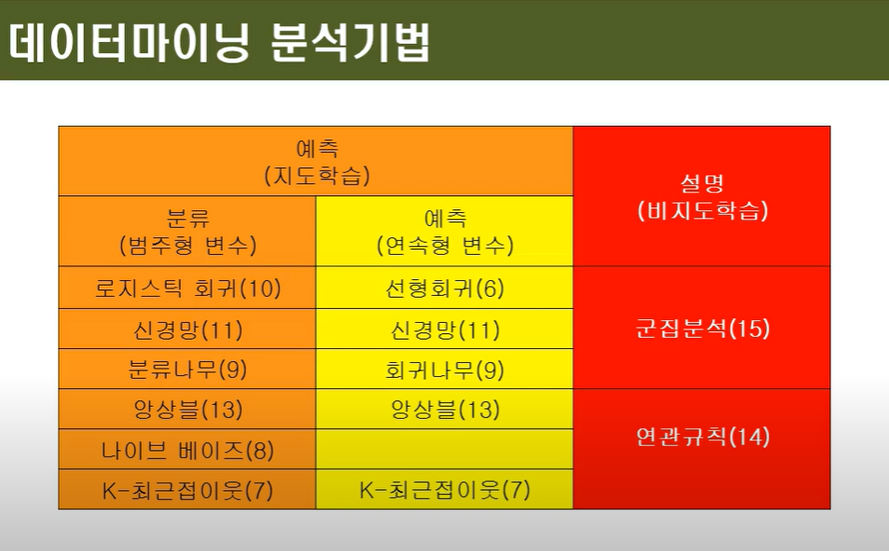

* 이후에는 선형모형들을 활용한 예측을 수행한다.  
분석에 앞서 우선 라이브러리들을 로드한다. 

In [13]:
# 사이킷런에서 제공하는 선형 모형중, 대표적 모형 3개지를 불러옵니다. 
# 선형회귀모형, Ridge, 라쏘 
from sklearn.linear_model import LinearRegression, Ridge, Lasso
# 최적의 독립변수를 찾아주는 모듈 
from sklearn.model_selection import GridSearchCV
# 선형대수적 연산 
from sklearn import metrics 

# ? 
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

[Grid Search CV 설명 자료! 제일 좋음]("https://datascienceschool.net/03%20machine%20learning/14.01%20%EB%AA%A8%ED%98%95%20%EC%B5%9C%EC%A0%81%ED%99%94.html")

## 회귀 모형

### Linear Regression Model

* 선형회귀 또는 최소제곱법은 가장 간단하고 오래된 회귀용 선형 알고리즘
* 선형회귀는 예측과 훈련 세트에 있는 타깃 y사이의 평균제곱오차(MSE)를 최소화하는 파라미터 w와 b를 찾는다.
* 매개변수가 없는 것이 장점이지만, 모델의 복잡도를 제어할 수 없다는 단점이 있다.
* 아래 위키피디아에서 가져 온 그래프에서 파란선이 선형회귀 모델을 나타내고 빨간점들이 훈련데이터를 나타낸다.

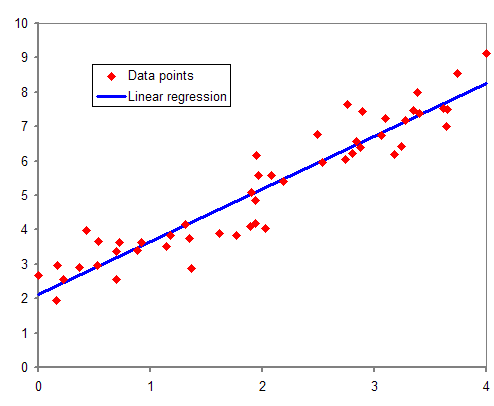

* [gridsearch|최적의 설명변수쌍 찾아준다]("https://teddylee777.github.io/scikit-learn/grid-search-%EB%A1%9C-hyperparameter%EC%B5%9C%EC%A0%81%ED%99%94")  

* [CV에 대한 설명]("https://tensorflow.blog/2018/03/13/%EB%8B%A4%EC%A4%91-%ED%8F%89%EA%B0%80-%EC%A7%80%ED%91%9C-cross_validate/")  

* [log1P는 뭐야?|넘피 로그변환]("https://rfriend.tistory.com/295")

In [14]:
# 1. 선형회귀모델을 초기화하기 
L_model = LinearRegression()

# 2. fit()을 통해 모델을 학습 시키기 
# 우선 모형 학습 이전에 y데이터를 로그화해줍니다. 
y_train_log = np.log1p(y_train) #logip는 -무한대값을 방지하는 변환 
# 이제 트레인 데이터를 통해 모형을 학습 시켜줍니다. 
L_model.fit(X_train,y_train_log)

# 3. 학습된 모델을 통해, x_train 데이터를 입력시 결과를 예측합니다. 
pred = L_model.predict(X_train)

# 4. 모델의 정확도를 평가합니다.
# 이때 RMLSE 지표를 활용하여 점수를 산출합니다. 
print ("RMSLE Value For Linear Regression: ",
       rmsle(np.exp(y_train_log),np.exp(pred), False))

RMSLE Value For Linear Regression:  0.9803697923313502


### 릿지 Regularization Model - Ridge

* 회귀를 위한 선형모델
* 가중치(w)의 모든 원소가 0에 가깝게 만들어 모든 피처가 주는 영향을 최소화(기울기를 작게 만듦)
* Regularization(정규화)는 오버피팅(과대적합)이 되지 않도록 모델을 강제로 제한한다는 의미
* max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.

In [15]:
from sklearn.linear_model import Ridge 

R_model = Ridge() # 우선 릿지 모형을 초기화 해줍니다. 
# 릿지 모형에 들어갈 파라미터 값을 선 지정해줍니다. 
# 최대 반복횟수를 3000회로 제한하며, 일련의 알파값을 지정합니다. 
ridge_params_ = {'max_iter':[3000],'alpha':[0.01,0.1,1,2,3,4,10,30,100,200,300,400,800,900,1000]}
# 평가 지표 또한 기존에 정의한 RMSLE 함수를 호출해 활성화합니다. 
rmsle_scorer = metrics.make_scorer(rmsle,greater_is_better=False)
# GridsearchCV는 일종의 자동화 도구입니다. 
# 특정 함수를 반복적으로 수행하며, 최적의 파라미터 값을 찾아냅니다.
# 또한, CV 즉, cross Validation 교차검증을 자동으로 진행합니다. 
grid_ridge_m = GridSearchCV(R_model,
                           ridge_params_,
                           scoring=rmsle_scorer,
                           cv=5) # 5겹의 교차검증 


# 실제적인 적합 단계에 들어갑니다. 
# 계산의 속도를 위해(?) 데이터의 크기를 줄이기 위해? 로그변환을 수행합니다. 
y_train_log = np.log1p(y_train)
grid_ridge_m.fit(X_train,y_train_log)
preds = grid_ridge_m.predict(X_train)
print("최적의 파라미터 : ",grid_ridge_m.best_params_)
print("RMSLE value For Ridge Regression: ",rmsle(np.exp(y_train_log),
                                                 np.exp(preds),
                                                 False))

df = pd.DataFrame(grid_ridge_m.cv_results_)
df.head()

최적의 파라미터 :  {'alpha': 0.01, 'max_iter': 3000}
RMSLE value For Ridge Regression:  0.9803697902780828


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010165,0.005933,0.003997,0.001106,0.01,3000,"{'alpha': 0.01, 'max_iter': 3000}",-1.003138,-0.906726,-1.029928,-1.016631,-0.982313,-0.987747,0.043461,1
1,0.006188,0.001154,0.003185,0.000403,0.1,3000,"{'alpha': 0.1, 'max_iter': 3000}",-1.003140,-0.906726,-1.029928,-1.016630,-0.982315,-0.987748,0.043461,2
2,0.006567,0.000492,0.003605,0.000501,1,3000,"{'alpha': 1, 'max_iter': 3000}",-1.003167,-0.906727,-1.029927,-1.016621,-0.982331,-0.987755,0.043461,3
3,0.005579,0.000803,0.003007,0.000020,2,3000,"{'alpha': 2, 'max_iter': 3000}",-1.003196,-0.906728,-1.029926,-1.016612,-0.982349,-0.987762,0.043461,4
4,0.005185,0.000398,0.002786,0.000396,3,3000,"{'alpha': 3, 'max_iter': 3000}",-1.003226,-0.906729,-1.029925,-1.016602,-0.982366,-0.987770,0.043460,5


In [16]:
# alpha값에 따른 RMSLE 점수를 보기 위해  별도의 데이터 프레임을 구성합니다. 
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
df[["alpha", "rmsle"]].head()

,alpha,rmsle
0,0.01,0.987747
1,0.10,0.987748
2,1.00,0.987755
3,2.00,0.987762
4,3.00,0.987770


<AxesSubplot:xlabel='alpha', ylabel='rmsle'>

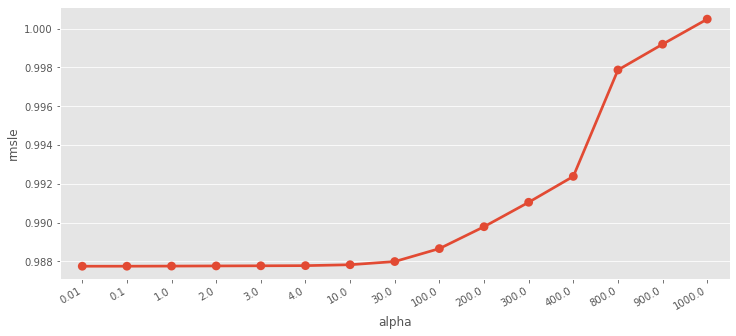

In [17]:
# 위의 결과를 시각화합니다.
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

### 라쏘 Regularization Model - Lasso

* 선형회귀의 Regularization(규제)를 적용하는 대안
* 계수를 0에 가깝게 만들려고 하며 이를 L1규제라고 하며, 어떤 계수는 0이 되기도 하는데 이는 완전히 제외하는 피처가 생긴다는 의미다.
* 피처 선택이 자동으로 이루어진다고도 볼 수 있다.
* alpha 값의 기본 값은 1.0이며, 과소 적합을 줄이기 위해서는 이 값을 줄여야 한다.
* 그리드 서치로 아래 라쏘모델을 실행했을 때 베스트 알파값은 0.0025
max_iter(반복 실행하는 최대 횟수)는 3000을 넣어주었다.

[Lasso 모형 설명 맛집]("https://m.blog.naver.com/khinv/220934574588")
* 요약 : 기존의 선형회귀 모형은 변수를 추가할 수록 변수간의 강한 선형 종속관계가 발생하는 다중공선성 문제가 발생한다. 이를 해결하시 위해 중요도가 떨어지는 변수의 계수의 절댓값을 크게 낮추는 방법이 Lasso 모형이다. (다중공선성 해결을 위해 고안된 모형)

In [18]:
from sklearn.linear_model import Lasso

lasso_model = Lasso() # 모델 초기화 

# 랏소모형 초기 변수 설정  
alpha = 1/np.array([0.1,1,2,3,4.10,30,100,200,300,400,800,900,1000])
lasso_params_ = {'max_iter':[3000],'alpha':alpha}

#  GridsearchCV 메소드를 통한 자동화 
# 최적의 변수를 자동으로 설정하며, 또한 CV 교차검증을 수행합니다. 
grid_lasso_m = GridSearchCV(lasso_model, lasso_params_, scoring= rmsle, cv=5)
y_train_log = np.log1p(y_train) # y데이터를 로그 변환하여 넣어줍니다. 
# train data로 모형을 학습 시킵니다. 
grid_lasso_m.fit(X_train,y_train_log)

# 예측을 수행합니다. 
preds = grid_lasso_m.predict(X_train)

# 그리드서치cv를 통해 찾은 최적의 입력을 찾습니다. 
print(grid_lasso_m.best_params_)
# RMSLE 점수를 출력합니다. 
print("RMSLE Value For Lasso Regression: ", rmsle(np.exp(y_train_log),np.exp(preds),False))
# 그리드서치의 교차검증 값들을 데이터 프레임에 담아 출력합니다. 
df = pd.DataFrame(grid_lasso_m.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x :-x)

df[["alpha","rmsle"]].head()


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [19]:
# test 
def testing(a=True):
    if a: 
        print("yes!")
    print("the end")
    
testing(a=False)

the end


<AxesSubplot:xlabel='alpha', ylabel='rmsle'>

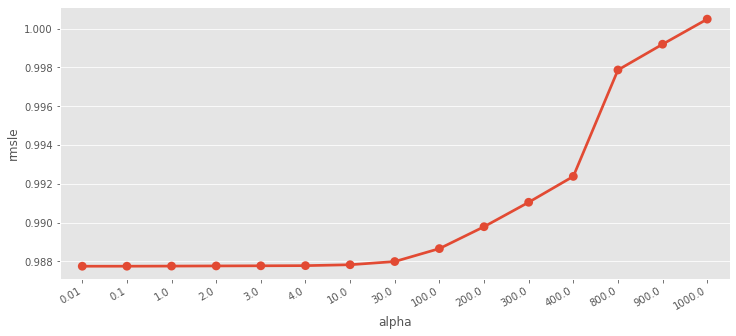

In [20]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
plt.xticks(rotation=30, ha='right')
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

## 앙상블 모델  
**Ensemble Models**

* 앙상블 모형이란 여러개의 분류기(분류모형)를 결합하여 하나의 메타 분류기로 연결해 사용하는 모델을 의미함
* 방법 : 
    1. 여러 분류 알고리즘 사용 : 다수결 투표(voting)
    2. 하나의 분류 알고리즘 사용 : 배깅(Bagging), 부스팅(Boosting)
* 종류:
    1. 투표(Majority Voting) : 동일한 훈련셑에 여러가지 분류기를 붙여 쓰는 방식 
    2. 배깅(Bagging) : 훈련 샘플에서 알고리즘마다 별도의 훈련세트 추출   
    ex) Random Forest :의사결정 나무
    3. 부스팅(Boosting): 샘플을 뽑을 때 잘못 분류된 data 50%를 재학습, 또는 가중치 이용 

### 앙상블 모형 이론 설명 

#### 과반수 투표 ( Majority Voting)

* 방법 : 동일한 훈련세트로 모델 구축
    1. 하나의 훈련세트를 가지고 여러개의 분류 모델을 이용하여 각각 예측을 수행(선형 회귀 모델, 의사결정트리모델, KNN모델 ...) 
    2. 서로 다른 각각의 예측값들을 종합해 과반의 모델이 동일하게 예측한 값을 전체 모형의 결과로 사용한다. 
    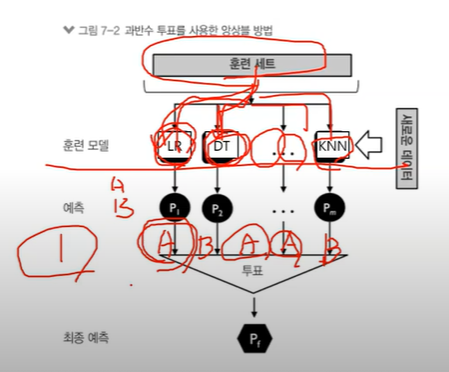

#### 배깅(Bagging) 
* 방법 : 
    1. 훈련샘플에서 알고리즘마다 별도의 훈련 세트를 추출해서 모델 구축 
    2. 이때, 부트스트랩(Bootstrap) 실시 : 데이터로 부터 복원추출(중복허용)을 이용
    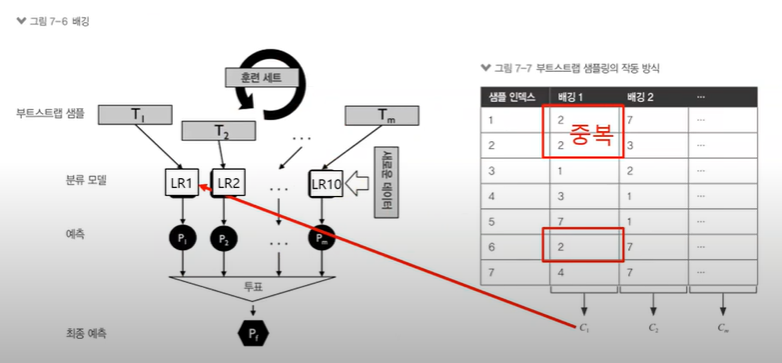
    
**하나의 분류모델을 사용한다. 다만, 각각의 모형에 서로 다른 여러개의 옵션을 지정해 모형을 구축한다.**

**cf) 의사결정 나무**  
* 목표 : 예측변수를 기반으로 결과를 분류하거나 예측하는것  
* 결정규칙(Dicision Rule)을 나무구조(tree)로 도표화 하여 분류(Classification)와 예측(prediction)을 수행하는 분석방법  
* 규칙 :  
    * IF (income <= 104.5)  
    * AND (CCAvg <=2.95)  
    * THEN Class = No(거절)
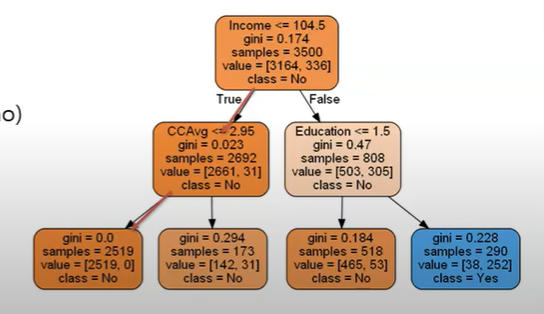
* 주요 방법 : 
    1. Tree and Rules 구조 :  
        1) 규칙(rules)은 나무모델(tree diagram)로 표현  
        2) 결과는 규칙으로 표현
    2. 재귀적 분할(Recursive partitioning)  
        1) 나무를 만드는 과정   
        2) 그룹이 최대한 동질하도록 반복적으로 레코드를 하위 그룹으로 분리 (나무를 계속 키워준다, 분할을 여러번 이룬다)--> 즉, 하나의 leaf(node)에 있는 데이터의 특성이 한가지 특성으로 치우칠 때 까지 분할  
        
    3. 가지치기(Pruning the tree)  
        1) 생성된 나무를 자르는 과정(정교화)  
            -> 나무를 성장 시킬때 부터, 좋은 성능을 갖도록 고려하여 모형을 성장시키거나(stop rule을 사전에 지정)  
            -> 나무를 일단 성장 시킨후, 마지막에 가지를 쳐주는 방식  
        2) 과적합을 피하기 위해 필요없는 가지를 간단히 정리  
* 적용 분야:  
 ex) 은행대출 : 도산업체 분류 
     카드발급 대상 : 신용불량자 분류
     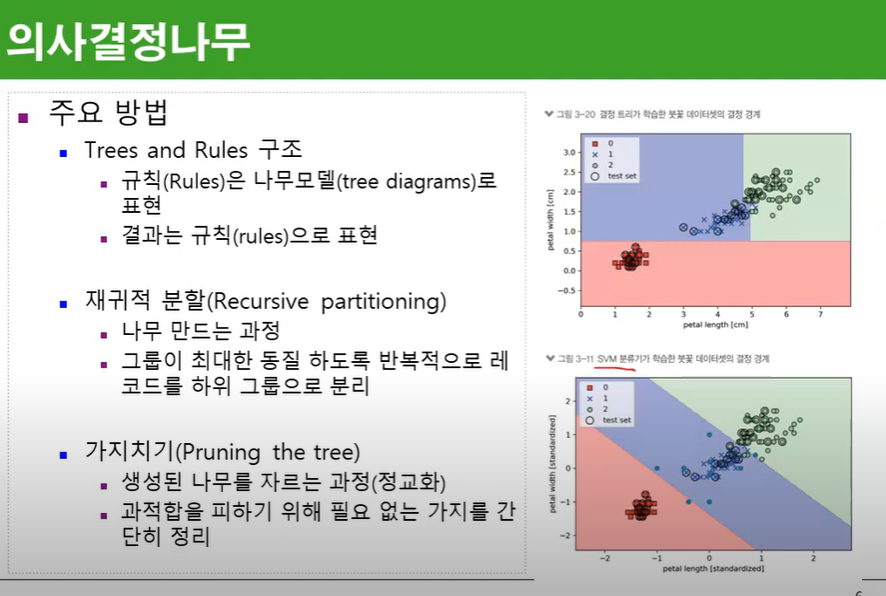
(SVM 이라는 분류기의 그림)
수직선으로 전체를 절반으로 나누어 가며,데이터를 그룹화시킴

* **의사결정 나무의 구분**  
    1) 분류나무(Classification Tree) : 목표변수가 범주형 변수 -> 분류  
    2) 회귀나무(Regression tree) : 목표 변수가 수치형 변수 -> 예측이 목적  
* **재귀적 분할 알고리즘 (R)**  
    1) CART(Classification And Regression Tree) - 분류와 회귀 모두  
    2) C4.5 - C5.0  
    3) CHAID (Chi-square Automatic Interaction Detection)
* **불순도(Impurity) 알고리즘**  
    : 하나의 그룹(노드) 안에 성격이 다른 데이터의 비중이 어느정도 되는지 검사 
    1) 지니지수(Gini index)  
    2) 엔트로피 지수(Entropy index) 정보이익(information Gain)  
    3) 카이제곱 통계량 (Chi-square statistic)

**의사결정 나무의 구분**
* 분류나무  
    1. 목표변수 : 범주형 변수(분리가 목적)  
    2. 분류 알고리즘과 불순수도 지표  
        * CART : 지니지수  
        * C4.5 : 엔트로피, 정보이익, 정보이익비율  
        * CHAID : 카이제곱통계량  
    3. 끝마디 : 각 그룹이 속하는 범주를 표시 
* 회귀나무  
    1. 목표 변수 : 수치형 데이터(예측을 목적으로 함)  
    2. 분류 알고리즘과 불순수도 지표 :  
        * CART 알고리즘 , F통계량과 분산의 감소량  
    3. 끝마디 : 집단의 평균을 표시   
    **예측일 경우 회귀나무보다 신경나무 또는 회귀분석이 더 우월함**
    
* 분리 방식에 따른 의사결정 나무 알고리즘 구분 
    1) 이지분리(binary split) : CART  
    2) 다지분리(multi-way split) : CHAID, C4.5, C5.0 ...
    
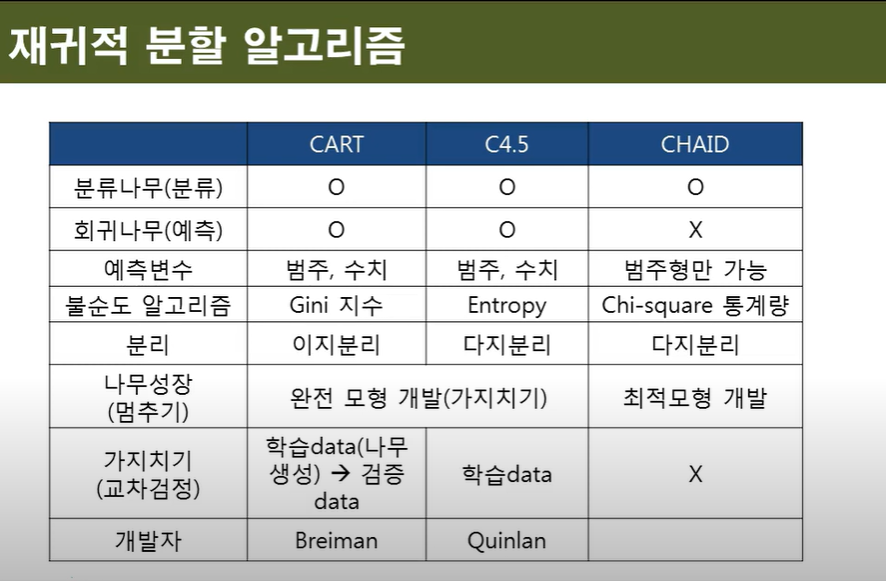

* **의사결정나무 생성과정**  
    1. 나무 모델 생성  
        * 재귀적 분할 방법을 이용하여 나무모델 생성  
        * CART(Gini), C4.5(Entropy), CHAID(Chi-squre) 이용--> 괄호안에 있는 지표를 이용하여 해당값이 낮아지는 모델을 찾는 방식으로 모형 구성  
    2. 과적합 문제 해결  
        * 나무 모델 생성하면서 최적의 모델이 완성되었을때 생성을 중지(stop) <-- CHAID  
        * 완전나무 모형 생성후 가지치기(CART, C4.5)  
            * 학습데이터만을 가지고 :C4.5  
            * 학습 데이터(나무생성) -> 검증데이터(가지치기): CART  
     3. 검증  
         * 교차타당성을 이용하여 의사결정나무 평가(CV : Cross Validation 교차검증)  
         

### Random Forest

* [부스트스트랩, 랜덤포레스트]("https://www.youtube.com/watch?v=lIT5-piVtRw")

In [21]:
# 앙상블 모형이 들어있는 ensemble 에서 랜덤 포레스트 모형을 불러옵니다 
from sklearn.ensemble import RandomForestRegressor

# 랜덤포레스트 모형의 초기 설정을 담아줍니다(초기화)
rf_model = RandomForestRegressor()

# 모형에 대입하기 위해 y값에 로그를 취해줍니다. 
y_train_log = np.log1p(y_train)

# 모형에 train 데이터셋을 적합해 학습시킵니다.
rf_model.fit(X_train,y_train_log)

# 트레인 데이터를 통해 모형의 예측을 시도합니다. 
preds = rf_model.predict(X_train)
# 예측 성능을 평가합니다. 
score = rmsle(np.exp(y_train_log),np.exp(preds),False)
print("RMSLE SCORE : ",score)

RMSLE SCORE :  0.10663923622778203


### 앙상블모델 - 그라디언트 부스트

**Ensemble Model - Gradient Boost**

* 여러개의 결정트리를 묶어 강력한 모델을 만드는 또 다른 앙상블 기법
* 회귀와 분류에 모두 사용할 수 있음
* 랜덤포레스트와 달리 이진 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만든다.
* 무작위성이 없고 강력한 사전 가지치기가 사용 됨
* 1~5개의 깊지 않은 트리를 사용하기 때문에 메모리를 적게 사용하고 예측이 빠름
* learning_rate : 오차를 얼마나 강하게 보정할 것인지를 제어
* n_estimator의 값을 키우면 앙상블에 트리가 더 많이 추가 되어 모델의 복잡도가 커지고 훈련세트에서의 실수를 바로잡을 기회가 많아지지만 너무 크면 모델이 복잡해지고 오버피팅(과대적합)이 될 수있다.
* max_depth(max_leaf_nodes) 복잡도를 너무 높이지 말고 트리의 깊이가 5보다 깊어지지 않게 한다.